In [439]:
import numpy as np
import pandas as pd
from cvxopt.modeling import variable, solvers, op
import matplotlib.pyplot as plt

In [440]:
usinas_hidro = [{
    "Nome": "UHE1",
    "Vmax": 100.,
    "Vmin": 20.,
    "Prod": 0.95,
    "Engol": 60.,
    "Afluencia": [[23,16],[19,14],[15,11]]
}]

usinas_termo = [
{
    "Nome": "TERM1",
    "Capacidade": 15.,
    "Custo": 10.
},
{
    "Nome": "TERM2",
    "Capacidade": 10.,
    "Custo": 25.
}
]

d_gerais = {
    "CDef": 500.,
    "Carga": [50.,50.,50.],
    "n_discretizacoes": 3,
    "n_estagios": 3,
    "n_cenarios": 2
}

sistema = {
    "DGer": d_gerais,
    "UHE": usinas_hidro,
    "UTE": usinas_termo,
}
print(sistema['DGer'])

{'CDef': 500.0, 'Carga': [50.0, 50.0, 50.0], 'n_discretizacoes': 3, 'n_estagios': 3, 'n_cenarios': 2}


In [441]:
def despacho(sistema, vol_inicial, afluencia, potecorte, mes, verbose=False):
    n_UHE = len(sistema["UHE"])
    n_UTE = len(sistema["UTE"])
    vol_final = variable(n_UHE)
    vol_turbinado = variable(n_UHE)
    vol_vertido = variable(n_UHE)
    ger_termica = variable(n_UTE)
    deficit = variable(1)
    custo_futuro = variable(1)

    fob = 0
    for i,usi in enumerate(sistema["UTE"]):
        fob += usi["Custo"]*ger_termica[i]
    
    fob += sistema["DGer"]["CDef"]*deficit[0]

    for i,usi in enumerate(sistema["UHE"]):
        fob+= 0.01*vol_vertido[i]
    
    fob += 1.0*custo_futuro[0]

    restricoes = []
    #Balanço Hídrico
    for i,usi in enumerate(sistema["UHE"]):
        restricoes.append( vol_final[i] == float(vol_inicial[i])+ float(afluencia[i])-vol_turbinado[i] -vol_vertido[i])
    
    #Atendimento a Demanda
    atendimento_demanda = 0
    for i,usi in enumerate(sistema["UHE"]):
        atendimento_demanda += usi["Prod"]*vol_turbinado[i]
    for i,usi in enumerate(sistema["UTE"]):
        atendimento_demanda += ger_termica[i]
    atendimento_demanda+=deficit[0]
    restricoes.append(atendimento_demanda==sistema['DGer']['Carga'][mes-2])

    #Restrição de Canalização
    for i,usi in enumerate(sistema["UHE"]):
        restricoes.append(vol_final[i]>=usi["Vmin"])
        restricoes.append(vol_final[i]<=usi["Vmax"])
        restricoes.append(vol_turbinado[i]>=0)
        restricoes.append(vol_turbinado[i]<=usi["Engol"])
        restricoes.append(vol_vertido[i]>=0)
    for i,usi in enumerate(sistema["UTE"]):
        restricoes.append(ger_termica[i]<=usi["Capacidade"])
        restricoes.append(ger_termica[i]>=0)
        
    restricoes.append(deficit[0]>=0)
    restricoes.append(custo_futuro[0]>=0)

    for corte in pote_de_corte:
        if corte["Estagio"] == mes:
            equacao = 0
            for usi in range(n_UHE):
                equacao += float(corte['Coefs'][usi])*float(vol_final[usi])
            equacao += float(corte['TermoIndependete'])
            restricoes.append(custo_futuro[0] >= equacao)

    problema = op(fob,restricoes).solve('dense','glpk')

    DGer = {
        "Defict": deficit[0].value()[0],
        "CMO": restricoes[n_UHE].multiplier.value[0],
        "CustoTotal": fob.value()[0],
        "CustoFuturo": custo_futuro[0].value()[0]
    }

    hidro_usis = []
    for i,usi in enumerate(sistema["UHE"]):
        result = {
            "volume_final": vol_final[i].value()[0],
            "volume_turbinado": vol_turbinado[i].value()[0],
            "volume_vertido": vol_vertido[i].value()[0],
            "CMA": restricoes[i].multiplier.value[0]
        }
        hidro_usis.append(result)
        
    termo_usis = []
    for i,usi in enumerate(sistema["UTE"]):
        result = {
            "geracao_termica": ger_termica[i].value()[0],
        }
        termo_usis.append(result)

    resultado = {
        "DGer": DGer,
        "UHE": hidro_usis,
        "UTE": termo_usis
    }

    if verbose:
        print(f'Custo Total = {fob.value()}')

        for i,usi in enumerate(sistema['UHE']):
            print(f"Volume Final {sistema['UHE'][i]['Nome']} = {vol_final[i].value()}")
            print(f"Volume Turbinado {sistema['UHE'][i]['Nome']} = {vol_turbinado[i].value()}")
            print(f"Volume Vertido {sistema['UHE'][i]['Nome']} = {vol_vertido[i].value()}")
            print('#'*70)
        
        for i,usi in enumerate(sistema['UTE']):
            print(f"Geração Termica {sistema['UTE'][i]['Nome']} = {ger_termica[i].value()}")

        print(f'Defict = {deficit[0].value()}')

        for i,usi in enumerate(sistema['UHE']):
            print(f"Valor da água Usina {sistema['UHE'][i]['Nome']}  = {restricoes[i].multiplier.value}")
    
        print(f'Custo Marginal da Operação = {restricoes[n_UHE].multiplier.value}')
        print(f'Custo Futuro da Operação = {custo_futuro[0].value()}')
    return resultado



[-475.0]
[-4.75]
[-0.0]


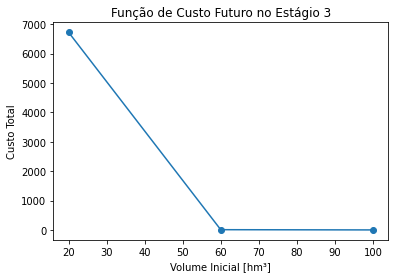

[-475.0]
[-0.0]
[-0.0]


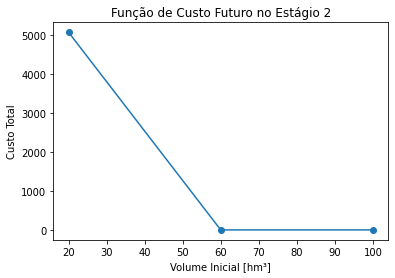

[-475.0]
[-0.0]
[-0.0]


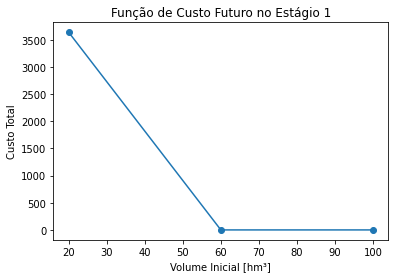

In [442]:
from itertools import product
import numpy as np

passo = 100/(sistema["DGer"]["n_discretizacoes"]-1)
discretizacoes = list(product(np.arange(0,100+passo,passo), repeat=len(sistema["UHE"])))

#loop de estagios
for iest in np.arange(sistema["DGer"]["n_estagios"],0,-1):
    plt.figure(iest)
    plt.title(f'Função de Custo Futuro no Estágio {iest}')
    plt.xlabel('Volume Inicial [hm³]')
    plt.ylabel('Custo Total')
    eixox = []
    eixoy = []
    pote_de_corte = []
    #loop de discretizações
    for discretizacao in discretizacoes:
        volume_inicial = []
        for i,usi in enumerate(sistema["UHE"]):
            volume_inicial.append(usi["Vmin"]+((usi["Vmax"]-usi["Vmin"])*discretizacao[i]/100))
        eixox.append(volume_inicial[0])
        media = 0
        media_cma = []
        for i,usi in enumerate(sistema["UHE"]):
            media_cma.append(0)           
        #loop de cenarios
        for icen in np.arange(0,sistema["DGer"]["n_cenarios"]):
            afluencia = []
            for i, usi in enumerate(sistema["UHE"]):
                afluencia.append(usi["Afluencia"][iest-1][icen])
            #print('-'*30,f'ESTAGIO {iest}','-'*30)
            resultado = despacho(sistema,volume_inicial,afluencia, potecorte=pote_de_corte, mes=iest+1)
            media += resultado["DGer"]["CustoTotal"]
            for i,usi in enumerate(resultado["UHE"]):
                media_cma[i] += usi["CMA"]            
        media = media/sistema["DGer"]["n_cenarios"]
        termo_independente = media
        for i,usi in enumerate(resultado["UHE"]):
            media_cma[i] = -media_cma[i] / sistema["DGer"]['n_cenarios']
            termo_independente -= volume_inicial[i]*media_cma[i]
        corte = {
            "Estagio": iest,
            "TermoIndependete": termo_independente,
            "Coefs": media_cma
        }
        pote_de_corte.append(corte)
        eixoy.append(media)
        print(media_cma)
        
    plt.plot(eixox,eixoy, marker='o')
    plt.show()


In [443]:
despacho(sistema,[62],[15],pote_de_corte,2,verbose=True)

Custo Total = [-7.11e-17]

Volume Final UHE1 = [ 2.44e+01]

Volume Turbinado UHE1 = [ 5.26e+01]

Volume Vertido UHE1 = [-7.11e-15]

######################################################################
Geração Termica TERM1 = [ 0.00e+00]

Geração Termica TERM2 = [ 0.00e+00]

Defict = [ 0.00e+00]

Valor da água Usina UHE1  = [ 0.00e+00]

Custo Marginal da Operação = [ 1.73e-18]

Custo Futuro da Operação = [ 0.00e+00]



{'DGer': {'Defict': 0.0,
  'CMO': 1.734723475976807e-18,
  'CustoTotal': -7.105427357601002e-17,
  'CustoFuturo': 0.0},
 'UHE': [{'volume_final': 24.368421052631582,
   'volume_turbinado': 52.631578947368425,
   'volume_vertido': -7.105427357601002e-15,
   'CMA': 0.0}],
 'UTE': [{'geracao_termica': 0.0}, {'geracao_termica': 0.0}]}